In [1]:
import numpy as np
import re

In [2]:
# ロードしたデータを訓練データ用のStringと正解ラベルに分ける
def split_vector(data):
    dic = {'b':0, 't':1, 'e':2, 'm':3}
    y = np.zeros(len(data) - 1)
    x = []
    for i, d in enumerate(data):
        if i == len(data) - 1:
            break
        y[i] = dic[d[0]]
        x.append(d[1])
    
    return (x, y.astype(np.uint8))

In [3]:
# 70
file_path = 'data/NewsAggregatorDataset/'

with open(file_path + 'train.txt') as f:
    train_data = f.read().split('\n')
x_train, y_train = split_vector([d.split('\t') for d in train_data])
print(len(x_train), y_train.shape)

with open(file_path + 'test.txt') as f:
    test_data = f.read().split('\n')
x_test, y_test = split_vector([d.split('\t') for d in test_data])
print(len(x_test), y_test.shape)

with open(file_path + 'valid.txt') as f:
    valid_data = f.read().split('\n')
x_valid, y_valid = split_vector([d.split('\t') for d in valid_data])
print(len(x_valid), y_valid.shape)

8708 (8708,)
1089 (1089,)
1088 (1088,)


In [4]:
from gensim.models import KeyedVectors
news_path = 'data/GoogleNews-vectors-negative300.bin'
words = KeyedVectors.load_word2vec_format(news_path, binary = True)

In [5]:
def vec2sum(x_data, dim):
    pattern = re.compile(r'[a-z|A-Z]+', re.MULTILINE + re.VERBOSE)  
    vector_sum = np.zeros((len(x_data), dim))
    for i, s in enumerate(x_data):
        vector = np.zeros(dim) 
        cnt = 0
        ss = pattern.findall(s)
        for noun in ss:
            try :
                cnt += 1
                vector += words[noun]
            except KeyError as error:
                continue
        if cnt == 0:
            continue
        vector_sum[i] = (vector / cnt)

    return vector_sum

In [6]:
x_feature = vec2sum(x_train, 300)
print(len(x_train))
print(x_feature.shape)


8708
(8708, 300)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.autograd import Variable
dim = words['US'].shape[0] # 単語ベクトルの次元

In [8]:
# 71
w = torch.randn(dim, 4, requires_grad = True)
x_feature = torch.tensor(x_feature, requires_grad = True)
y = func.softmax(torch.matmul(x_feature[:1].float(), w))

print(y)


tensor([[0.2101, 0.1099, 0.4896, 0.1904]], grad_fn=<SoftmaxBackward>)


/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [9]:
# 複数事例
Y = func.softmax(torch.mm(x_feature[:4].float(), w), dim = 1)
print(Y)

tensor([[0.2101, 0.1099, 0.4896, 0.1904],
        [0.0282, 0.0713, 0.8676, 0.0328],
        [0.1484, 0.2994, 0.4518, 0.1005],
        [0.2162, 0.0345, 0.6334, 0.1159]], grad_fn=<SoftmaxBackward>)


In [10]:
from math import exp, log

criterion = nn.CrossEntropyLoss()
y_train = torch.tensor(y_train.astype(float), requires_grad = True)

# 単体事例
y_ = criterion(torch.mm(x_feature[:1].float(), w), y_train[:1].long())
print(y_)
y_.backward()
print(w.grad)

# 複数事例
Y_ = criterion(torch.mm(x_feature[:4].float(), w), y_train[:4].long())
print(Y_)
Y_.backward()
print(w.grad)

# 検算
ans = []
for yy, i in zip(Y, y_train[:4].long()):
    ans.append(-log(yy[i]))
print(sum(ans) / len(ans))

tensor(0.7142, grad_fn=<NllLossBackward>)
tensor([[-0.0035, -0.0018,  0.0086, -0.0032],
        [ 0.0234,  0.0122, -0.0569,  0.0212],
        [-0.0027, -0.0014,  0.0066, -0.0025],
        ...,
        [-0.0181, -0.0095,  0.0439, -0.0164],
        [-0.0068, -0.0035,  0.0165, -0.0061],
        [-0.0031, -0.0016,  0.0075, -0.0028]])
tensor(1.8079, grad_fn=<NllLossBackward>)
tensor([[-2.5401e-02,  9.0519e-03,  2.6699e-02, -1.0349e-02],
        [ 5.8273e-05,  2.4451e-02, -5.9702e-02,  3.5192e-02],
        [ 1.0362e-02, -3.7857e-03, -2.9207e-03, -3.6552e-03],
        ...,
        [-2.8388e-02, -7.2523e-03,  7.3001e-02, -3.7360e-02],
        [-6.5748e-03, -1.3002e-03,  2.1948e-02, -1.4073e-02],
        [ 1.5427e-02, -7.2951e-03,  1.2897e-02, -2.1029e-02]])
1.8078829358594413


In [11]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
class MyNet(nn.Module):
    def __init__(self, input_size):
        super(MyNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 4)
        
    def forward(self, x):
        x = self.fc1(x)
        return x

In [13]:
mynet = MyNet(dim)
optimizer = optim.SGD(mynet.parameters(), lr = 0.01, momentum = 0.9)
num_epochs = 100
save_path = '../data/params.tar'

In [14]:
class Model():
    def __init__(self, model):
        self.model = model
        
    def set_params(self, num_epochs, num_batches, optimizer, criterion):
        # エポック数，バッチサイズ，最適化アルゴリズム，損失関数の初期化
        self.num_epochs = num_epochs
        self.num_batches = num_batches
        self.optimizer = optimizer
        self.criterion = criterion
        
        # epoch毎の損失と精度を保持するリスト
        self.losses = np.zeros(num_epochs)
        self.accs = np.zeros(num_epochs)

    def fit(self, x_train, y_train):
        num_data = x_train.shape[0]
        for epoch in range(self.num_epochs):

            # epoch毎の損失と精度
            running_loss = 0.0
            accuracy = 0.0

            # 開始時間
            t = time.time()

            # ミニバッチ学習のために訓練データのインデックスをランダムに並べ替える
            index = np.random.permutation(num_data)

            for i in range(0, num_data, self.num_batches):
                # NNへの入力と正解ラベル
                in_, label = torch.tensor(x_train[index[i : i + self.num_batches if i + self.num_batches < num_data else num_data]]), \
                             torch.tensor(y_train[index[i : i + self.num_batches if i + self.num_batches < num_data else num_data]]).long()

                # 最適化関数の初期化
                self.optimizer.zero_grad()

                # 予測とロスの計算
                out_ = self.model(in_.float())
                loss = self.criterion(out_, label)

                _, idx = torch.max(out_, 1)

                # バッチ数のラベルが出てくるので，いくつ正解しているかカウント
                cnt = 0
                for i in range(idx.shape[0]):
                    if idx[i] == label[i]:
                        cnt += 1
                accuracy += cnt / idx.shape[0]

                # パラメーターの更新
                loss.backward()
                optimizer.step()
                running_loss += loss.data

            # 各種データの出力・保存
            num_loop = num_data / self.num_batches
            accuracy /= num_loop
            loss = running_loss / num_loop
            print('[ epoch:{0}, time:{3} ]  acc: {1:.4f}  loss:{2:.4f}'.format(epoch + 1, accuracy, loss, time.time() - t))
            self.accs[epoch] = accuracy
            self.losses[epoch] = loss
 
            # 状況の保存
            torch.save({
              'epoch': epoch,
              'model_state_dict': self.model.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'loss': loss,
              'accuracy': accuracy,
              }, save_path)
    
    def predict(self, x):
        out_ = self.model(x)
        return out_
    
    def evaluate(self, x, y):
        p = self.predict(x)
        _, idx = torch.max(p, 1)
        cnt = 0
        for i in range(idx.shape[0]):
            if idx[i] == y[i]:
                cnt += 1
        accuracy = cnt / idx.shape[0]
        
        return accuracy
    
    def visualize(self):
        x = np.arange(len(self.accs))
        fig = plt.figure()
        ax = fig.add_subplot(211)
        ax.plot(x, self.accs, color = 'red', linewidth = 2, label = 'accuracy')
        ax2 = fig.add_subplot(212)
        ax2.plot(x, self.losses, color = 'green', linewidth = 2, label = 'loss')
        ax.legend()
        ax2.legend()
        plt.plot()
    

In [15]:
model = Model(mynet)
model.set_params(num_epochs, 1, optimizer, criterion)

In [16]:
model.fit(x_feature, y_train)

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[ epoch:1, time:2.60729718208313 ]  acc: 0.8746  loss:0.3750
[ epoch:2, time:2.5130889415740967 ]  acc: 0.9112  loss:0.2622
[ epoch:3, time:2.541531801223755 ]  acc: 0.9167  loss:0.2416
[ epoch:4, time:2.503795862197876 ]  acc: 0.9213  loss:0.2288
[ epoch:5, time:2.58841609954834 ]  acc: 0.9217  loss:0.2200
[ epoch:6, time:2.6453371047973633 ]  acc: 0.9271  loss:0.2146
[ epoch:7, time:2.6515591144561768 ]  acc: 0.9258  loss:0.2094
[ epoch:8, time:2.6174979209899902 ]  acc: 0.9302  loss:0.2045
[ epoch:9, time:2.670179843902588 ]  acc: 0.9295  loss:0.2020
[ epoch:10, time:2.6888248920440674 ]  acc: 0.9308  loss:0.1973
[ epoch:11, time:2.6032052040100098 ]  acc: 0.9308  loss:0.1956
[ epoch:12, time:2.9106197357177734 ]  acc: 0.9310  loss:0.1945
[ epoch:13, time:2.7122268676757812 ]  acc: 0.9320  loss:0.1922
[ epoch:14, time:2.6172149181365967 ]  acc: 0.9329  loss:0.1901
[ epoch:15, time:2.604681968688965 ]  acc: 0.9353  loss:0.1888
[ epoch:16, time:2.682664155960083 ]  acc: 0.9337  loss:0

In [17]:
model.evaluate(x_feature.float(), y_train)

0.9440744143316491

In [18]:
model.evaluate(torch.tensor(vec2sum(x_valid, dim)).float(), y_valid)

0.921875

In [19]:
model.evaluate(torch.tensor(vec2sum(x_test, dim)).float(), y_test)

0.9292929292929293

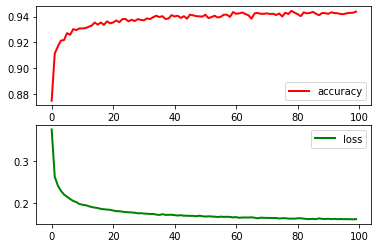

In [20]:
model.visualize()

In [21]:
model2 = Model(mynet)
model2.set_params(num_epochs, 4, optimizer, criterion)

In [22]:
model2.fit(x_feature, y_train)

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[ epoch:1, time:0.7016558647155762 ]  acc: 0.9464  loss:0.1553
[ epoch:2, time:0.6954078674316406 ]  acc: 0.9451  loss:0.1554
[ epoch:3, time:0.692861795425415 ]  acc: 0.9455  loss:0.1551
[ epoch:4, time:0.6954569816589355 ]  acc: 0.9464  loss:0.1550
[ epoch:5, time:0.725492000579834 ]  acc: 0.9466  loss:0.1549
[ epoch:6, time:0.714123010635376 ]  acc: 0.9463  loss:0.1551
[ epoch:7, time:0.7157549858093262 ]  acc: 0.9453  loss:0.1552
[ epoch:8, time:0.7153515815734863 ]  acc: 0.9448  loss:0.1550
[ epoch:9, time:0.712878942489624 ]  acc: 0.9456  loss:0.1549
[ epoch:10, time:0.7107789516448975 ]  acc: 0.9465  loss:0.1552
[ epoch:11, time:0.712792158126831 ]  acc: 0.9463  loss:0.1550
[ epoch:12, time:0.7167139053344727 ]  acc: 0.9461  loss:0.1551
[ epoch:13, time:0.7162256240844727 ]  acc: 0.9458  loss:0.1548
[ epoch:14, time:0.7138607501983643 ]  acc: 0.9465  loss:0.1550
[ epoch:15, time:0.715705156326294 ]  acc: 0.9471  loss:0.1546
[ epoch:16, time:0.7129809856414795 ]  acc: 0.9457  los

In [23]:
class MyNet2(nn.Module):
    def __init__(self, input_size, h_size, output_size):
        super(MyNet2, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, h_size)
        self.fc2 = torch.nn.Linear(h_size, int(h_size / 2))
        self.fc3 = torch.nn.Linear(int(h_size / 2), output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = func.relu(x)
        x = self.fc2(x)
        x = func.relu(x)
        x = self.fc3(x)
        return x

In [24]:
mynet = MyNet2(dim, 100, 4)
optimizer = optim.SGD(mynet.parameters(), lr = 0.01, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
save_path = '../data/params.tar'

model = Model(mynet)
model.set_params(num_epochs, 2, optimizer, criterion)

In [25]:
model.fit(x_feature, y_train)

/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/taimu/yes/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[ epoch:1, time:2.5642709732055664 ]  acc: 0.8528  loss:0.4188
[ epoch:2, time:2.5996220111846924 ]  acc: 0.9057  loss:0.2720
[ epoch:3, time:2.6187350749969482 ]  acc: 0.9163  loss:0.2374
[ epoch:4, time:2.6041150093078613 ]  acc: 0.9223  loss:0.2172
[ epoch:5, time:2.6414101123809814 ]  acc: 0.9280  loss:0.2003
[ epoch:6, time:2.621795177459717 ]  acc: 0.9335  loss:0.1840
[ epoch:7, time:2.607133150100708 ]  acc: 0.9362  loss:0.1744
[ epoch:8, time:2.604882001876831 ]  acc: 0.9402  loss:0.1599
[ epoch:9, time:2.605173110961914 ]  acc: 0.9436  loss:0.1480
[ epoch:10, time:2.5979998111724854 ]  acc: 0.9483  loss:0.1397
[ epoch:11, time:2.586045980453491 ]  acc: 0.9528  loss:0.1268
[ epoch:12, time:2.5987942218780518 ]  acc: 0.9595  loss:0.1163
[ epoch:13, time:2.605975866317749 ]  acc: 0.9587  loss:0.1117
[ epoch:14, time:2.6124019622802734 ]  acc: 0.9639  loss:0.0971
[ epoch:15, time:2.594650983810425 ]  acc: 0.9665  loss:0.0904
[ epoch:16, time:2.622886896133423 ]  acc: 0.9675  loss:

In [26]:
print(model.evaluate(x_feature.float(), y_train))
print(model.evaluate(torch.tensor(vec2sum(x_valid, dim)).float(), y_valid))

0.9990813045475425
0.9292279411764706


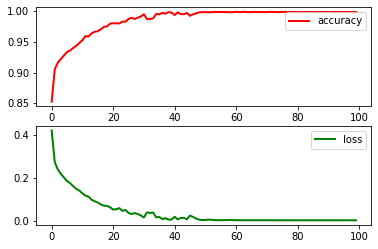

In [27]:
model.visualize()